In [20]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

import torch.optim as optim
from torchvision import transforms, models
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm

In [21]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = (False)

In [22]:
#device = torch.device("cuda:0")
device = torch.device('cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [23]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = in_transform(image).unsqueeze(0)
    return image

In [24]:
style = '/Users/zachbloss/Downloads/pink watercolor.jpeg'
content = '/Users/zachbloss/Documents/Sara bday gift/EMU grad.jpeg'

content = load_image(content).to(device)
style = load_image(style, shape=content.shape[-2:]).to(device)

In [25]:
# city = load_image('../images/City.jpg').to(device)
# mona = load_image('../images/MonaLisa.jpg').to(device)

# content = city
# star = load_image('../images/StarryNight.jpg', shape=content.shape[-2:]).to(device)
# style = star

In [26]:
def image_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    return image

(-0.5, 399.5, 499.5, -0.5)

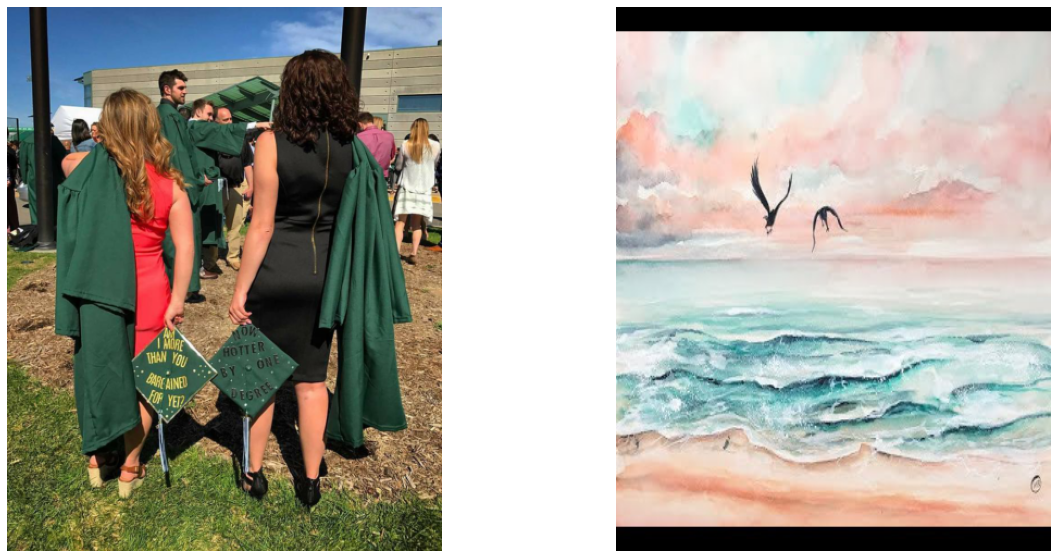

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(image_convert(content))
ax1.axis('off')

ax2.imshow(image_convert(style))
ax2.axis('off')

In [28]:
def get_features(image, model):
    
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2', # we will use this one for content extraction
        '28': 'conv5_1'
    }
    
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)    
        if name in layers:
            features[layers[name]] = image
            
    return features

In [29]:
content_features = get_features(image=content, model=vgg)
style_features = get_features(image=style, model=vgg)

In [30]:
def gram_matrix(tensor):
    batch, depth, height, width = tensor.size()
    
    tensor = tensor.view(depth, height*width) # reshaped into a 2D tensor
    gram = torch.mm(tensor, tensor.t())
    return gram

In [31]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [32]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1
style_weight = 10^6

In [33]:
target = content.clone().requires_grad_(True).to(device)

In [34]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 300 * 34

In [35]:
height, width, channels = image_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps / 300

counter = 0

  3%|███▉                                                                                                                                   | 299/10201 [04:42<2:40:17,  1.03it/s]

Iteration: 300
Total Loss: 28.504671096801758


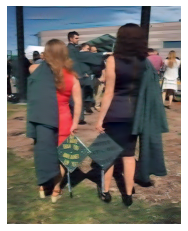

  6%|███████▉                                                                                                                               | 599/10201 [09:36<2:39:28,  1.00it/s]

Iteration: 600
Total Loss: 18.899911880493164


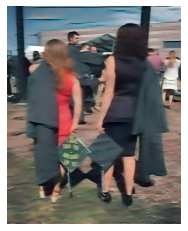

  9%|███████████▉                                                                                                                           | 899/10201 [14:38<2:36:59,  1.01s/it]

Iteration: 900
Total Loss: 15.235671043395996


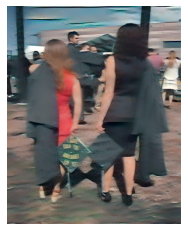

 12%|███████████████▊                                                                                                                      | 1199/10201 [19:44<2:34:31,  1.03s/it]

Iteration: 1200
Total Loss: 13.177433013916016


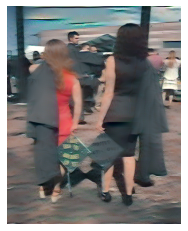

 15%|███████████████████▋                                                                                                                  | 1499/10201 [24:53<2:28:33,  1.02s/it]

Iteration: 1500
Total Loss: 11.718732833862305


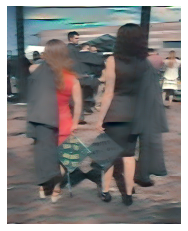

 18%|███████████████████████▋                                                                                                              | 1799/10201 [30:01<2:21:51,  1.01s/it]

Iteration: 1800
Total Loss: 10.549816131591797


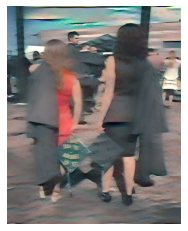

 21%|███████████████████████████▌                                                                                                          | 2099/10201 [34:49<2:09:09,  1.05it/s]

Iteration: 2100
Total Loss: 9.55565357208252


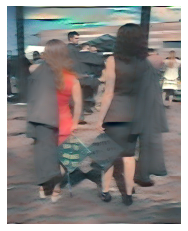

 24%|███████████████████████████████▌                                                                                                      | 2399/10201 [39:36<2:06:11,  1.03it/s]

Iteration: 2400
Total Loss: 8.689081192016602


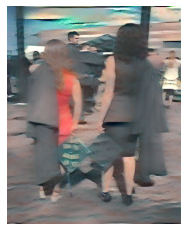

 26%|███████████████████████████████████▍                                                                                                  | 2699/10201 [44:27<2:00:06,  1.04it/s]

Iteration: 2700
Total Loss: 7.938108444213867


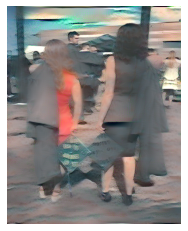

 29%|███████████████████████████████████████▍                                                                                              | 2999/10201 [49:19<1:57:09,  1.02it/s]

Iteration: 3000
Total Loss: 7.291974067687988


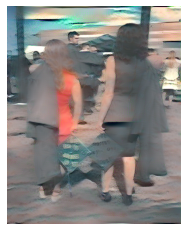

 32%|███████████████████████████████████████████▎                                                                                          | 3299/10201 [54:18<1:53:32,  1.01it/s]

Iteration: 3300
Total Loss: 6.735541343688965


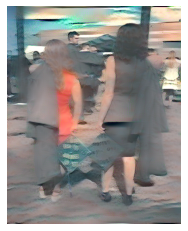

 35%|███████████████████████████████████████████████▎                                                                                      | 3599/10201 [59:17<1:52:43,  1.02s/it]

Iteration: 3600
Total Loss: 6.258674621582031


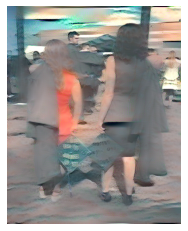

 38%|██████████████████████████████████████████████████▍                                                                                 | 3899/10201 [1:04:21<1:45:34,  1.01s/it]

Iteration: 3900
Total Loss: 5.865442276000977


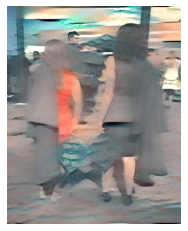

 41%|██████████████████████████████████████████████████████▎                                                                             | 4199/10201 [1:09:29<1:42:20,  1.02s/it]

Iteration: 4200
Total Loss: 5.542038917541504


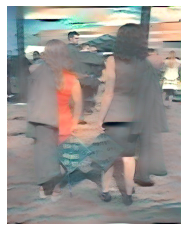

 44%|██████████████████████████████████████████████████████████▏                                                                         | 4499/10201 [1:14:39<1:37:27,  1.03s/it]

Iteration: 4500
Total Loss: 5.27911901473999


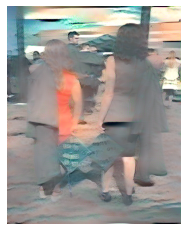

 47%|██████████████████████████████████████████████████████████████                                                                      | 4799/10201 [1:19:51<1:34:26,  1.05s/it]

Iteration: 4800
Total Loss: 5.065227031707764


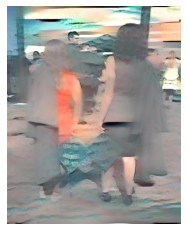

 50%|█████████████████████████████████████████████████████████████████▉                                                                  | 5099/10201 [1:25:02<1:30:15,  1.06s/it]

Iteration: 5100
Total Loss: 4.898212909698486


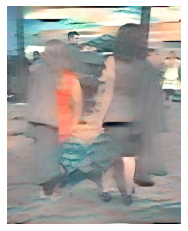

 53%|█████████████████████████████████████████████████████████████████████▊                                                              | 5399/10201 [1:30:13<1:23:36,  1.04s/it]

Iteration: 5400
Total Loss: 4.763335704803467


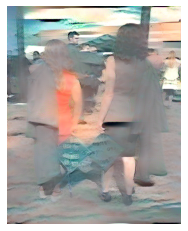

 56%|█████████████████████████████████████████████████████████████████████████▋                                                          | 5699/10201 [1:35:25<1:17:16,  1.03s/it]

Iteration: 5700
Total Loss: 4.654213905334473


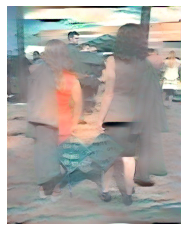

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                      | 5999/10201 [1:40:37<1:14:44,  1.07s/it]

Iteration: 6000
Total Loss: 4.562199592590332


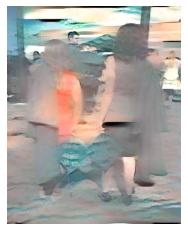

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                  | 6299/10201 [1:45:49<1:07:54,  1.04s/it]

Iteration: 6300
Total Loss: 4.482049942016602


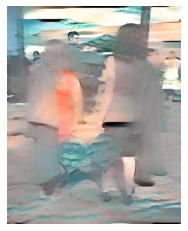

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                              | 6599/10201 [1:51:05<1:05:55,  1.10s/it]

Iteration: 6600
Total Loss: 4.408754825592041


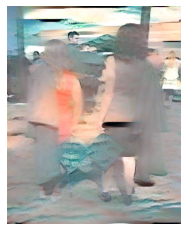

 68%|██████████████████████████████████████████████████████████████████████████████████████████▋                                           | 6899/10201 [2:20:54<54:05,  1.02it/s]

Iteration: 6900
Total Loss: 4.339005947113037


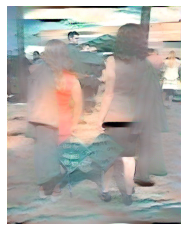

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7199/10201 [8:33:07<53:18,  1.07s/it]

Iteration: 7200
Total Loss: 4.273110389709473


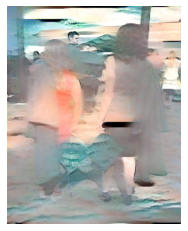

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7499/10201 [8:38:02<44:47,  1.01it/s]

Iteration: 7500
Total Loss: 4.2140069007873535


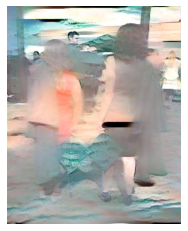

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7799/10201 [8:43:15<40:30,  1.01s/it]

Iteration: 7800
Total Loss: 4.161595344543457


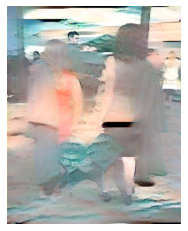

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8099/10201 [8:48:30<36:50,  1.05s/it]

Iteration: 8100
Total Loss: 4.114663124084473


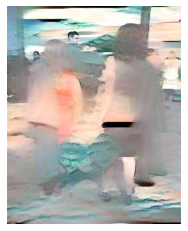

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8399/10201 [8:59:08<30:03,  1.00s/it]

Iteration: 8400
Total Loss: 4.0754714012146


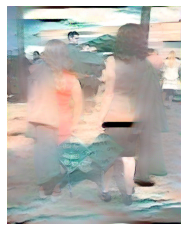

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8699/10201 [9:04:04<24:19,  1.03it/s]

Iteration: 8700
Total Loss: 4.041414737701416


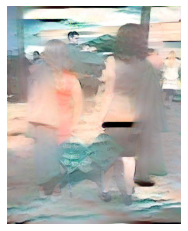

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8999/10201 [9:09:04<20:42,  1.03s/it]

Iteration: 9000
Total Loss: 4.010519981384277


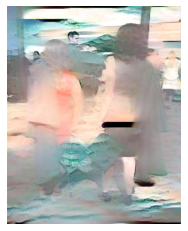

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9299/10201 [9:14:19<16:12,  1.08s/it]

Iteration: 9300
Total Loss: 3.9842801094055176


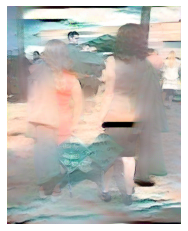

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9599/10201 [9:19:29<10:09,  1.01s/it]

Iteration: 9600
Total Loss: 3.9604384899139404


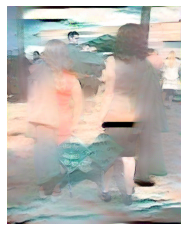

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9899/10201 [9:24:43<05:15,  1.05s/it]

Iteration: 9900
Total Loss: 3.939743995666504


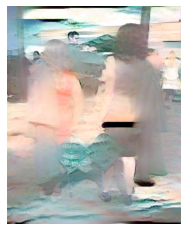

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 10199/10201 [9:29:55<00:02,  1.04s/it]

Iteration: 10200
Total Loss: 3.9211182594299316


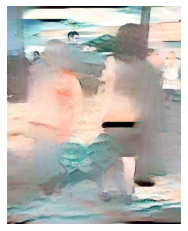

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 10200/10201 [9:29:57<00:03,  3.35s/it]


In [36]:
for ii in tqdm(range(1, steps+1), total=steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, depth, height, width = target_feature.shape
        
        style_loss += layer_style_loss / (depth * height * width)
        
    total_loss = content_loss*content_weight + style_loss*style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print(f'Iteration: {ii}')
        print(f'Total Loss: {total_loss.item()}')
        plt.imshow(image_convert(target))
        plt.axis('off')
        plt.show()
        
    if ii % capture_frame == 0:
        image_array[counter] = image_convert(target)
        counter += 1
        

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))

ax1.imshow(image_convert(content))
ax1.axis('off')

ax2.imshow(image_convert(style))
ax2.axis('off')

ax3.imshow(image_convert(target))
ax3.axis('off')

In [ ]:
frame_height, frame_width, _ = image_convert(target).shape
vid = cv2.VideoWriter(
    '../output/emu_grad_pink_watercolor.mp4', 
    cv2.VideoWriter_fourcc(*'XVID'), 
    30, 
    (frame_width, frame_height)
)
for i in range(len(image_array)):
    img = image_array[i]
    img = img * 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)
vid.release()

In [ ]:
for i in content_features:
    print(i)
    plt.imshow(image_convert(content_features[i]))